<h1> <u> Analysis on Amazon's Mechanical Turk Crowd-Sourcing System </u> </h1> <BR>
<hr>

Suppose we have a bunch of URLs and we want to know their adult-rating
(i.e., is the url P, or G, or X, or R). This task is dicult for computers,
but easy for humans, and this has led to the growth of crowdsourcing: get
a bunch of humans to give ratings to urls, but use automated techniques to
figure out how much to trust each person's ratings.
We are going to use the data from a paper by Ipeirotis et al. available
here. This details an experiment run on Amazon's Mechanical Turk crowd-
sourcing system. They ask a bunch of raters (called \turks") to rate several
urls, but they already know the answers (the true categories) for a few urls,
called the \gold set". The ratings of the turks on the gold set thus allows us
to judge their accuracy.

In [1]:
#Imports
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<HR><H2> Read in data<HR>

In [2]:
gold_df=pd.read_csv('gold.txt',
                      sep='\t',      # use this field separator
                      header=None,   # do not use the first line as a header
                      names=['url', 'category'])
gold_df.head()


,url,category
0,http://0800-horoscope.com,G
1,http://18games.net,X
2,http://1pixelout.net,G
3,http://1porno.com/004/teens/index.html,X
4,http://1stpussy.com/005/16/index.html,X


In [3]:
labels_df=pd.read_csv('labels.txt',
                      sep='\t',      # use this field separator
                      header=None,   # do not use the first line as a header
                      names=['turk','url', 'category'])

labels_df.head()

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G


<HR><H2>Split into two DataFrames <HR>

<B>Approach:</B>
<OL><LI> Create labels_on_gold by filtering those urls that are in the gold set
    <li> Create labels_unknown by filtering those urls that are not in the gold set
</OL>

In [4]:
labels_on_gold=labels_df[(labels_df['url'].isin(list(gold_df['url'])))]
labels_unknown=labels_df[~(labels_df['url'].isin(list(gold_df['url'])))]

<HR><H2> Compute accuracies of turks<HR>

<B>Approach:</B>
<OL><LI> Create a new dataframe, called <b>correct_ratings</b>, which contains the no of correctly rated gold-set URLs for each turk
    <li> Create another dataframe, called <b>rater_goodness</b>, which count of gold set URLs rated by each turk
    <LI> Merge <b>rater_goodness</b> with correct_ratings, on the index (turks) and assign the result to rater_goodness
    <LI> Fill NAs for places where correct ratings are none with 0s and find avg correctness
</OL>

In [5]:
merged_df=labels_on_gold.merge(gold_df,on="url",suffixes=['_turk','_gold'],how="left")
merged_df=merged_df[merged_df['category_turk']==merged_df['category_gold']]
correct_ratings=merged_df.groupby('turk')['url'].count()

In [6]:
rater_goodness=labels_on_gold.groupby("turk").agg({"url":"count"}).sort_values(by='url',ascending=False).rename(columns={'url':'No of ratings'})
rater_goodness=rater_goodness.merge(correct_ratings,left_index=True,right_index=True,how="left")

In [7]:
rater_goodness.rename(columns={"url":"Correct ratings"},inplace=True)
rater_goodness['Correct ratings'].fillna(0,inplace=True)

In [8]:
rater_goodness['Avg Correctness']=rater_goodness['Correct ratings']/rater_goodness['No of ratings']
rater_goodness=rater_goodness[["No of ratings","Avg Correctness"]]
rater_goodness.sort_values(by="No of ratings",ascending=False,inplace=True)
rater_goodness.head(10)

,No of ratings,Avg Correctness
turk,,
A31OCN4MNHUQ6W,184,0.777174
A153PKAL7OAY36,148,0.722973
A2BTR0GQ5B5JI6,126,0.523810
ATVALOQVDCMZW,103,0.854369
AZSDW7JJL5VA7,100,0.680000
A3GE97GX3OXJTW,85,0.658824
A3JMQDTEKRE5X6,80,0.675000
A2JP3HEL3J25AJ,80,0.687500
A3MA9V9UPGCOK7,71,0.774648


In [9]:
len(rater_goodness)

269

<HR><H2>Odds ratios<HR>

In [10]:
rater_goodness["Odds"]=rater_goodness["Avg Correctness"]/(1.001 - rater_goodness["Avg Correctness"])

In [11]:
rater_goodness

,No of ratings,Avg Correctness,Odds
turk,,,
A31OCN4MNHUQ6W,184,0.777174,3.472222
A153PKAL7OAY36,148,0.722973,2.600369
A2BTR0GQ5B5JI6,126,0.523810,1.097695
ATVALOQVDCMZW,103,0.854369,5.826657
AZSDW7JJL5VA7,100,0.680000,2.118380
A3GE97GX3OXJTW,85,0.658824,1.925391
A3JMQDTEKRE5X6,80,0.675000,2.070552
A2JP3HEL3J25AJ,80,0.687500,2.192982
A3MA9V9UPGCOK7,71,0.774648,3.422313


<HR><H2>Most accurate turks<HR>

In [12]:
#Sort by average correctness where no of ratings > =20 and then select the top 10 turks
rater_goodness[rater_goodness["No of ratings"]>=20].sort_values(by="Avg Correctness",ascending=False).reset_index()[:10][['turk']]

,turk
0,A2U0R4X38GUKZE
1,A22C0PJUBFJTI0
2,A23YQUBXZPKILZ
3,ATVALOQVDCMZW
4,A1HIXWH4OXT8S4
5,A3220HG1O83HQ4
6,A32W20KGQXS0LL
7,A20PWAB7G3HDHU
8,AJSJVK40F5HM6
9,A31OCN4MNHUQ6W


<HR><H2>Rating counts versus accuracy<HR>

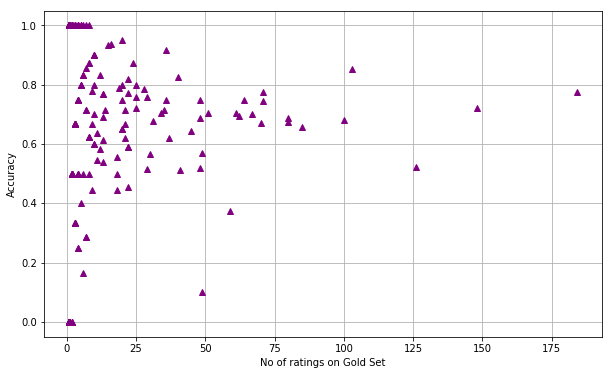

In [13]:
plt.figure(figsize=(10,6))
plot(rater_goodness['No of ratings'], rater_goodness['Avg Correctness'], 
     linestyle='None', 
     marker='^',
     color='purple')
xlabel("No of ratings on Gold Set")
ylabel("Accuracy")
plt.grid()

In [14]:
rater_goodness[['No of ratings','Avg Correctness']].corr()

,No of ratings,Avg Correctness
No of ratings,1.000000,0.045292
Avg Correctness,0.045292,1.000000


<b><i> As we can see from the graph & the table, there is negligible correlation (~4%) betweeen no of gold sets rated and avg correctness 

<HR><H2> Overall predicted odds <HR>

<B>Approach:</B>
<OL><LI> Find Label-Gold (read label minus gold)
    <li> Get the reliable turks 
        <OL><LI>Filter turks from rater_goodness where no of ratings>=1</li>
            <li>Filter turks which have rated more gold sets than 75% of all turks </li>
            <li>Filter turks which have rated u,v (Uncategorized data) </li>
        </ol>
    <LI> Find the product of odds for uncategorized URLs from the odd scores of reliable turks
</OL>

In [15]:
#------------------------------------
#Step1 : Find Labels - Gold
#------------------------------------
merged_df=pd.merge(labels_df,gold_df,on='url',how='left')
merged_df=merged_df[merged_df['category_y'].isnull()][["turk","url","category_x"]]

In [16]:
#-------------------------------------
#Step2 : Get reliable turks
#-------------------------------------

#   2.1 Filter turks from rater_goodness where right>=1
reliable_turks=rater_goodness[rater_goodness["No of ratings"]>=1]

#   2.2 Filter turks which have rated more gold sets than 75% of all turks
reliable_turks=reliable_turks[reliable_turks["No of ratings"]>reliable_turks["No of ratings"].quantile(0.75)]

#   2.3 Filter turks which have rated u,v
reliable_turks=list(reliable_turks.index.values)

merged_df=merged_df[merged_df['turk'].isin(reliable_turks)]

In [17]:
#---------------------------------------------------------------------------------------------
#Step 3 Find the product of odds for uncategorized URLs from the odd scores of reliable turks
#---------------------------------------------------------------------------------------------
uncategorized_odds=pd.merge(merged_df,rater_goodness.reset_index(),on="turk",how="left")[["turk","url","category_x","Odds"]]
uncategorized_odds=uncategorized_odds.groupby(['url','category_x'])['Odds'].prod().reset_index().rename(columns={'Odds':'Overall Odds'})
uncategorized_odds.sort_values(by="Overall Odds",ascending=False).head(10)

,url,category_x,Overall Odds
1021,http://affiliatetips.com,G,1.631168e+06
4068,http://daniweb.com,G,8.486887e+05
1741,http://asiaporno.com,X,5.632515e+05
4432,http://directmag.com,G,4.238277e+05
4430,http://directline-holidays.co.uk,G,4.238277e+05
4036,http://dailyom.com,G,3.559631e+05
4031,http://dailydesi.com,X,3.559631e+05
858,http://activemusician.com,G,2.426544e+05
864,http://actuarialoutpost.com,G,2.426544e+05
852,http://actden.com,G,2.426544e+05


<HR><H2> Predicted categories <HR>

<B>Approach:</B>
<OL><LI> Group by URL & Overall odds to find the category which has the highest odds for each url
    <li> Join this result with the result of the last question to get the top categories & their respective top odds for each URL and store it in <B>result_75</B>
</OL>

In [18]:
merged_df_q8=uncategorized_odds
top_odds=merged_df_q8.groupby('url')['Overall Odds'].max().reset_index()
result_75=top_odds.merge(merged_df_q8,on=["url","Overall Odds"],how="left")

In [19]:
result_75.rename(columns={'category_x':'Top Category','Overall Odds':'Top Odds'},inplace=True)
result_75.sort_values(by="url").head(10)

,url,Top Odds,Top Category
0,http://0-101.net,2.155963,G
1,http://000.cc,1.460583,G
2,http://0000.jp,14.488244,G
3,http://000relationships.com,5.681060,G
4,http://000vitamins.com,3.784982,G
5,http://000webhost.com,11.159502,G
6,http://003my.com,4.912040,G
7,http://007absolutehardcore.com/early_cumshots/...,293.252871,X
8,http://007swz.cn,1.393883,G
9,http://01768.com,1.393883,G


<HR><H2> Predicted categories using more turks <HR>

<B>Approach:</B>
<OL><LI> Create a <b>result_25</b> the same way as above but by tweaking the quantile condition by 25%
    <li> Perform an inner join on <b>result_25</b> and <b>result_75</b> and use the cross tab function to get the required answer
</OL>

<b><i>Part 1

In [20]:
#1 : Find Labels - Gold

merged_df2=pd.merge(labels_df,gold_df,on='url',how='left')
merged_df2=merged_df2[merged_df2['category_y'].isnull()][["turk","url","category_x"]]

In [21]:
#Step 2 : Get reliable turks
#   2.1 Filter turks from rater_goodness where right>=1

reliable_turks2=rater_goodness[rater_goodness["No of ratings"]>=1]

#   2.2 Filter turks which have rated more gold sets than 75% of all turks
reliable_turks2=reliable_turks2[reliable_turks2["No of ratings"]>reliable_turks2["No of ratings"].quantile(0.25)]

#   2.3 Filter turks which have rated u,v
reliable_turks2=list(reliable_turks2.index.values)
merged_df2=merged_df2[merged_df2['turk'].isin(reliable_turks2)]

In [22]:
#Step 3 Find the product of odds for uncategorized URLs from the odd scores of reliable turks
uncategorized_odds2=pd.merge(merged_df2,rater_goodness.reset_index(),on="turk",how="left")[["turk","url","category_x","Odds"]]
uncategorized_odds2=uncategorized_odds2.groupby(['url','category_x'])['Odds'].prod().reset_index().rename(columns={'Odds':'Overall Odds'})
uncategorized_odds2.sort_values(by="Overall Odds",ascending=False,inplace=True)
merged_df_q8_2=uncategorized_odds2
top_odds=merged_df_q8_2.groupby('url')['Overall Odds'].max().reset_index()
result_25=top_odds.merge(merged_df_q8_2,on=["url","Overall Odds"],how="left")

In [23]:
result_25.rename(columns={'category_x':'Top Category','Overall Odds':'Top Odds'},inplace=True)
result_25.sort_values(by="url").head(10)

,url,Top Odds,Top Category
0,http://0-101.net,2.155963e+00,G
1,http://000.cc,2.181050e+03,G
2,http://0000.jp,2.877556e+07,G
3,http://000relationships.com,1.851852e+00,P
4,http://000vitamins.com,5.014149e+00,G
5,http://000webhost.com,1.113723e+07,G
6,http://003my.com,4.912040e+00,G
7,http://007absolutehardcore.com/early_cumshots/...,5.847515e+02,X
8,http://007swz.cn,1.391101e+00,G
9,http://01768.com,1.393883e+00,G


<b><i>Part 2

In [24]:
final=pd.merge(result_75,result_25,on="url",how="inner" ,suffixes=['_75','_25'])
final=pd.crosstab(final['Top Category_75'],final['Top Category_25'])
final

Top Category_25,G,P,R,X
Top Category_75,,,,
G,8327,575,188,217
P,190,330,47,19
R,21,34,128,27
X,27,6,26,457
